+ Author: Ciarán O'Brien
+ Lecture: Jane Courtney
+ Submitted: 13/12/18
+ This code is in response to CA Class Test: Boundary Detection

In [1]:
# Boiler plate imports 
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import easygui
import imutils
import math
import operator

# Setup

Import all the necessary boiler plate code; import statements, header text.
Obtain important data; Flesh detection in different colour spaces. As the assignment was regrading skin colours, I needed to research what 
colour space and thresholding parameters were necessary here. For this, I took the given image of the skin mole, and used a colour picker tool, 
like Photoshop's colour picker tool, in order to obtain the RGB colours of the skin. I took 10 sample across the image and took an average of 
these values. 
Once I had the RGB vales, I used colorizer.org in order to obtain the HSV values for my chosen skin colour. The algorithm these values were used 
in will be discussed below, along with the code used afterwards.

# Requirements:

- Convert the image to an appropriate colour space;
- Enhance the image to maximise the contrast between the mole and the skin;
- Create a binary mask of the mole from the image using thresholding or edge detection;
- Use morphology to clean up this mask;
- Extract the contours in the binary image;
- Sort the contours by area to find the largest;
- Draw this contour on the original image as a thick red line;

# Method:

My method included 3 steps:

1. Masking
2. Morphological operation
3. FindContours

## 1. Masking:

As mentioned in my setup, I knew that I was dealing with skin colours, so decided to make use of the HSV colour space. Using the values researched 
form above,  min_HSV = [20, 70, 0] and max_HSV = [120, 200, 255], I was able to create a binary mask by using the inRange() fnx. 
The inRange() fnx take two parameters, the min and max values for your colour threshold. When we pass in the HSV image, the fnx filters out any 
other colours outside the parameter ranges, and returns a binary mask of the chosen range.This mask was returned from the getHSVMask fxn(). 
I did look at trying to use the YCrCb range, as that has proven useful in research for skin thresholding. However, the results I obtained from HSV 
masking we satisfactory. Further work on the mask is shown below.

## 2. Morphological operation:

The resulting mask from getHSVMask() fnx needed some cleaning up. For this, I made use of OpenCV's morphological operations. These operations 
alter the structure of a binary image, in our case a binary mask. I made use of two operations, closing and opening, with kernel sizes of (7,7) 
and (3,3) respectively.
Closing is a Dilation followed by an Erosion operation. Here missing holes in the mask, as per the result of getHSVMask(), are filled in relative 
to the background, black.
Opening an erosion followed by a dilation operation. Here background noise is removed relative to the kernel neighbours. The method implemented 
in the background here is when at least one kernel neighbour has a value of 1, then the pixel element being compared as the central pixel of the 
kernel, is set to a value of 1.

## 3. FindContours :

The final step in my method concluded with finding the contours of the binary mask, and using a contour to draw a red line around the found mole.
Firstly I made use of OpenCV's findContour() fnx with three parameters, the binary mask, the contour retrieval mode, and the contour approximation 
method.
The Binary mask has been defined as per the previous two steps in my method.
The contour retrieval mode is defined by a set of 5 modes as per OpenCV RetrievalModes documentation. I chose to use the RETR_LIST mode as it 
simply retrieves all the available contours and can be easily accessed just like a regular list. This will be useful, as I am required to sort 
the contours too.
The contour approximation mode is defined by a set of 5 modes as per OpenCV ContourApproximationModes documentation. I chose to use the 
CHAIN_APPROX_SIMPLE mode as it attempts to filter out false positive contours by compressing horizontal, vertical, and diagonal segments and 
leaves only their end points. However CHAIN_APPROX_NONE, which simply returns all contours found, returns the same number of contours, so either 
mode works.

As the contours are returned as a list, I can easily perform the required task of sorting them according to area size. I did this through the use 
of python's sorted fnx, which takes the list, the sorting key, and order as parameter.
The lists has been defined as the contours lits earlier
The sorting key, I use the area of the contours themselves, using cv2.contourArea.
The order, I set the reversOrder to True, so simply the first element in the list is the largest contours, therefore the contour of the mole.

# Testing:

## Error checking: 
Error checking occurs when we try to convert an image into HSV. As we can only safely say if an image has 2/3 channels, I built the error 
checking based around that. If the user selects a 2 channle input, an error will be raised. 

## Image Testing: 
Of the two images provided, my current method unfortunately works with one of the images. This is due to the fine tunig required for the 
getMorphologyMask() fnx. Hower, I have added an extra image found online that works with my method.

In [2]:
# Converting the Colour image into the HSV range
# The HSV range is more usefull than RGB, as it allows for capturing colours of diffrent Brightness and Saturation
def getHSVImage(colourImage):
    try: 
        if(len(colourImage.shape) == 2):
            raise Exception("Potential Gray Image passed. Not allowed!")
        elif(len(colourImage.shape) == 3):
            return cv2.cvtColor(colourImage.copy(), cv2.COLOR_BGR2HSV)
        else:
            raise Exception("Unsupported Image")
    except Exception as error:
        print("An error has occured\n",error)

In [3]:
def getHSVMask(HSVimage):
    min_HSV = np.array([20, 70, 0], dtype=np.uint8)
    max_HSV = np.array([120, 190, 255], dtype=np.uint8)
    skinMask = cv2.inRange(HSVimage, min_HSV, max_HSV)
    return skinMask

In [4]:
def getYCrCbMask(image):
    converted = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    min_YCrCb = np.array([0,133,77],dtype=np.uint8)
    max_YCrCb = np.array([255,173,127],dtype=np.uint8)
    skinMask = cv2.inRange(converted, min_YCrCb, max_YCrCb)
    skinMask[skinMask < 128] = 0
    skinMask[skinMask >= 128] = 1
    return skinMask

In [5]:
def getMorphologyMask(hsvMask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    mask = cv2.morphologyEx(hsvMask, cv2.MORPH_CLOSE, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(hsvMask, cv2.MORPH_OPEN, kernel, iterations=2)
    return mask

In [6]:
# Finding contours for the thresholded image
def getDrawContourImage(morphMask,originalImage):
    copy = originalImage.copy()
    contours, _ = cv2.findContours(morphMask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cntsSorted = sorted(contours, key=lambda x: cv2.contourArea(x))
    cnt = sorted(contours, key=cv2.contourArea, reverse=True)
    cv2.drawContours(copy,cnt[1],-1,(255,0,0),6)
    if(cnt[1][0][0][0] > 200):
        foundLargeContour = True
    else:foundLargeContour = False
    return copy,foundLargeContour

In [7]:
# Inform the user if they should get the mole looked at or not
def plotInformation(foundMole):
    if foundMole:
        return "Better get that checked out !"
    else:
        return "Sure looks grand !"

In [8]:
moleImage = plt.imread("mole.jpg")
moleImage2 = plt.imread("mole2.jpg")
skinCancerImage = plt.imread("skincancer.jpg")

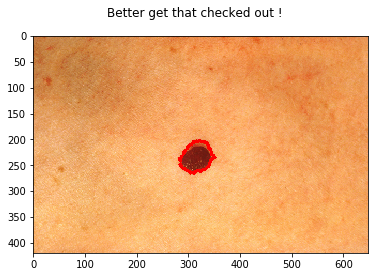

In [9]:
hsvImage = getHSVImage(moleImage)
hsvMask = getHSVMask(hsvImage)
morphMask = getMorphologyMask(hsvMask)
drawnImage,foundMole = getDrawContourImage(morphMask,moleImage)
plt.suptitle(plotInformation(foundMole))
plt.imshow(drawnImage)
plt.show()

In [10]:
import unittest

class TestNotebook(unittest.TestCase):

    def test_nonGrayImageReturned(self):
        grayColourImage = cv2.cvtColor(moleImage,cv2.COLOR_BGR2GRAY)
        try:
            getHSVImage(grayColourImage)
        except Exception:
            pass
        
unittest.main(argv=[''], verbosity=2, exit=False)

test_nonGrayImageReturned (__main__.TestNotebook) ... 

An error has occured
 Potential Gray Image passed. Not allowed!


ok

----------------------------------------------------------------------
Ran 1 test in 0.017s

OK
